In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
os.chdir("C:/Users/micha/OneDrive/Dokumenty/GitHub/Machine_Learning_Regression/Machine_Learning_Regression")
df = pd.read_csv('data/output/train_fe.csv', index_col=0)
df_test = pd.read_csv('data/output/test_fe.csv', index_col=0)
fr = pd.read_excel('data/output/feature_ranking.xlsx', index_col=0)

In [3]:

sample_1 = df.sample(500000, random_state=1)

In [4]:
fr

,mi_score,sign_fscore,boruta_rank,corr
mother_body_mass_index,0.010817,0.000000e+00,3,0.090487
mother_delivery_weight,0.037620,0.000000e+00,1,0.211110
mother_height,0.016931,0.000000e+00,1,0.158014
mother_weight_gain,0.021361,0.000000e+00,1,0.170464
father_age,0.004791,4.845727e-38,6,0.025690
father_education,0.007098,0.000000e+00,1,0.100219
cigarettes_before_pregnancy,0.003369,0.000000e+00,1,-0.079261
prenatal_care_month,0.005405,2.491900e-35,1,0.007138
number_prenatal_visits,0.023873,0.000000e+00,1,0.149988
previous_cesarean,0.001150,3.354504e-39,6,0.019234


In [7]:
boruta = fr[fr['boruta_rank'].isin([1])].index.tolist()
mi_score = fr[fr['mi_score'] > 0.01].index.tolist()
f_score = fr[fr['sign_fscore'] < 0.05].index.tolist()
Correlation = fr[(fr['corr'] > 0.1) | (fr['corr'] < -0.1)].index.tolist()
y_col = 'newborn_weight'

x_cols = {
    'boruta': boruta,
    'mi_score': mi_score,
    'f_score': f_score,
    'Correlation':Correlation
}

In [8]:
estimator = LinearRegression()
selector = RFECV(
    estimator,
    step=1,
    cv=5,
    min_features_to_select=9,
)
selector = selector.fit(
    df.loc[:, boruta].values, df.loc[:, "newborn_weight"].values.ravel()
)
print(df.loc[:, boruta].iloc[:, selector.support_].columns.tolist())
rfe_candidates = df.loc[:, boruta].iloc[:, selector.support_].columns.tolist()

['mother_delivery_weight', 'mother_height', 'mother_weight_gain', 'father_education', 'cigarettes_before_pregnancy', 'prenatal_care_month', 'number_prenatal_visits', 'newborn_gender', 'mother_delivery_weight_log', 'mother_marital_status_married', 'mother_marital_status_not_married', 'Black', 'smoker']


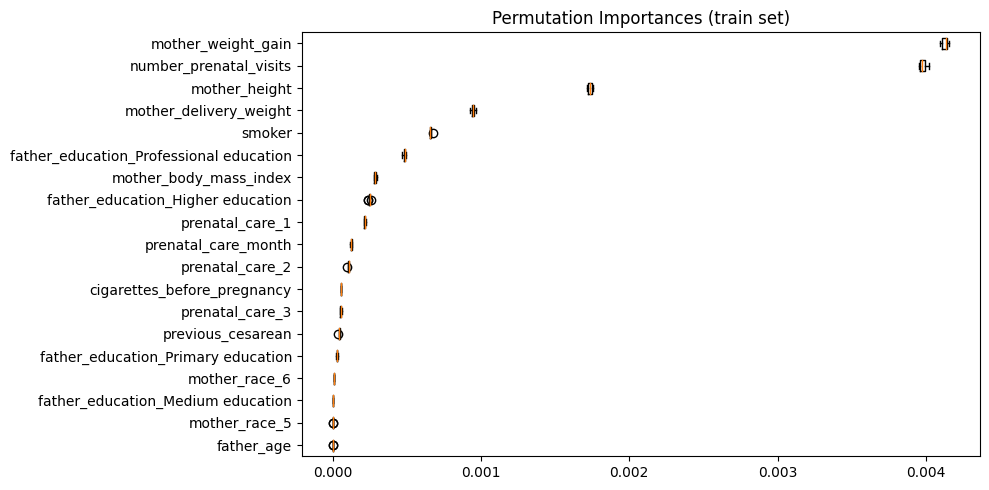

In [24]:
estimator = LinearRegression()
estimator.fit(df.loc[:, benchmark_input].values, df.loc[:, "newborn_weight"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, benchmark_input].values,
    df.loc[:, "newborn_weight"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_absolute_percentage_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, benchmark_input].columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [30]:
parameter_space = {
    "alpha": [1, 10, 100, 280, 500],
    "l1_ratio": [0.5, 1],
    "fit_intercept": [True, False],
}

clf = RandomizedSearchCV(ElasticNet(random_state=3), parameter_space, 
                   n_jobs=-1, cv=3, scoring="neg_mean_absolute_percentage_error")

clf.fit(df.loc[:, benchmark_input], df.loc[:, 'newborn_weight'])
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'l1_ratio': 1, 'fit_intercept': True, 'alpha': 1}


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute

In [20]:
base_model = SVR()

# Create a bagging regressor with the linear regression model as the base estimator
bagging_model = BaggingRegressor(base_model)

# Define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Evaluate model using cross-validation
scores = cross_val_score(bagging_model, df.loc[:, boruta], df.loc[:, 'newborn_weight'],
                        scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)

# Convert scores to positive values
scores = abs(scores)

# Calculate and print the mean and standard deviation of the scores
print('MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()))

### 2nd try


,mother_body_mass_index,mother_delivery_weight,mother_height,mother_weight_gain,father_age,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,mother_race_5,mother_race_6,father_education_Higher education,father_education_Medium education,father_education_Primary education,father_education_Professional education,prenatal_care_1,prenatal_care_2,prenatal_care_3,smoker
1044309,40.500000,272.0,66.0,21.0,31.0,10.0,1,12.0,1,0,0,0,1,0,0,1,0,0,1
1515065,26.800000,207.0,70.0,20.0,41.0,0.0,1,14.0,1,0,0,0,1,0,0,1,0,0,0
1157698,21.500000,150.0,64.0,25.0,42.0,0.0,1,12.0,0,0,0,1,0,0,0,1,0,0,0
1373212,36.100000,240.0,65.0,23.0,32.0,0.0,1,15.0,0,0,0,1,0,0,0,1,0,0,0
656314,33.826687,314.0,67.0,98.0,33.0,20.0,0,0.0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746046,22.600000,171.0,66.0,31.0,39.0,0.0,1,20.0,0,0,0,1,0,0,0,1,0,0,0
1197659,27.300000,163.0,60.0,23.0,30.0,0.0,1,11.0,0,0,0,1,0,0,0,1,0,0,0
795973,35.800000,242.0,65.0,27.0,32.0,0.0,1,11.0,0,0,0,0,1,0,0,1,0,0,0
734858,22.300000,155.0,61.0,37.0,42.0,0.0,1,13.0,1,0,0,0,0,0,1,1,0,0,0


In [9]:
from sklearn.neighbors import KNeighborsRegressor

parameter_space = {
    "n_neighbors": [9, 10, 11,50],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1,2,20,50,200]
}

clf = RandomizedSearchCV(KNeighborsRegressor(), parameter_space, cv=4, 
                   scoring="neg_mean_absolute_percentage_error", n_jobs=-1)

clf.fit(sample_1.loc[:, benchmark_input], sample_1.loc[:, 'newborn_weight'])
print("Best parameters:")
print(clf.best_params_)

In [ ]:
knn_model = KNeighborsRegressor(**clf.best_params_)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
knn_scores = cross_val_score(knn_model, df.loc[:, benchmark_input], df.loc[:, 'newborn_weight'], scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
# force scores to be positive
knn_scores = absolute(knn_scores)
print('MAPE: %.3f (%.3f)' % (mean(scores), std(scores)))